
# Model eigenvalues  

Eigenvalues play a crucial role in the dynamics of models, encapsulating the adjustment process within a model. They are pivotal in dynamic models as their sign and magnitude dictate whether a system will stabilize, diverge after a disturbance, or if such a disturbance will induce oscillations.

For macromodels, which are systems of (non)linear **difference** equations, the initial step involves linearizing the model by computing Jacobi matrices. Since the model may have lags longer than 1 so the linear model can be of an order higher than one, it is transformed into a first-order system by creating a companion matrix. The stability, marginal stability, or instability of the system is assessed based on the eigenvalues of this companion matrix.

The Modelflow library provides a comprehensive set of tools for calculating a model’s eigenvalues, facilitating the assurance of the model's dynamic stability and identifying potential sources of instability.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [3]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

## Import modelnewton

To calculate eigenvectors and eigenvalues of a model requires thate the newton_diff package from the modelnewton library (part of the modelflow package) be imported.

In [4]:
# Import to handle imaginary numbers 
import numpy as np 

# Import of modelflow lineraization methods. 
from modelnewton import newton_diff

## Load a model, data and descriptions 

For the purposes of this exposition the climate aware model for Pakistan described {cite:author}`burns_climate_2021` is used.

In [5]:
mpak,baseline = model.modelload('../models/pak.pcim')
baseline = mpak(baseline,2023,2100)

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


:::{index} single: modelflow; .newtondiff() method
:::
:::{index} single: modelnewton package; .newtondiff() method
:::

:::{index} single: model derivatives
:::

:::{index} single: eigenvalues and eigenvectors
:::

:::{index} single: modelflow; eigenvalues and eigenvectors
:::
## the method .newton_diff()

The `modelnewton` method `.newtondiff()` calculates the derivatives of the mpak model, and in the code block belows assigns the results to the object mpak_newton.


:::{index} single: eigenvalyues; .get_eigenvalues() method
:::
:::{index} single: modelflow; .get_eigenvalues() method
:::

### .get_eigenvalues method
The get_eigenvectors function calculates the actual eigenvectors of the model.  For a large model this can be a fairly time consuming calculation taking several minutes even on relatively powerful multicore i9 computers.

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::
Once the eigenvalues are calculated they can be displayed graphically with the `.eigplot_all()` method.

In [19]:
eig_dic = mpak.get_eigenvalues()

In [20]:
mpak_newton = mpak.stability_newton

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::

### .get_eigenplot_all method

The `.get_eigenplot_all()` method plots a polar diagram of the eigenvalues for a given year.  Eigenvalues with real roots are stable and will appear on the zero line. Ones unreal roots and values in excess of 1 are unstable.

Inspection of the polar diagrams reveals indicates that most of the eigenvalues are less than one, and that those that have unreal roots (those that appear off of the 0 degree line), only a few have imaginary roots outside of the unit circle which could be a source of model uncertainty (these are hard to see in the figure, but are identified below).

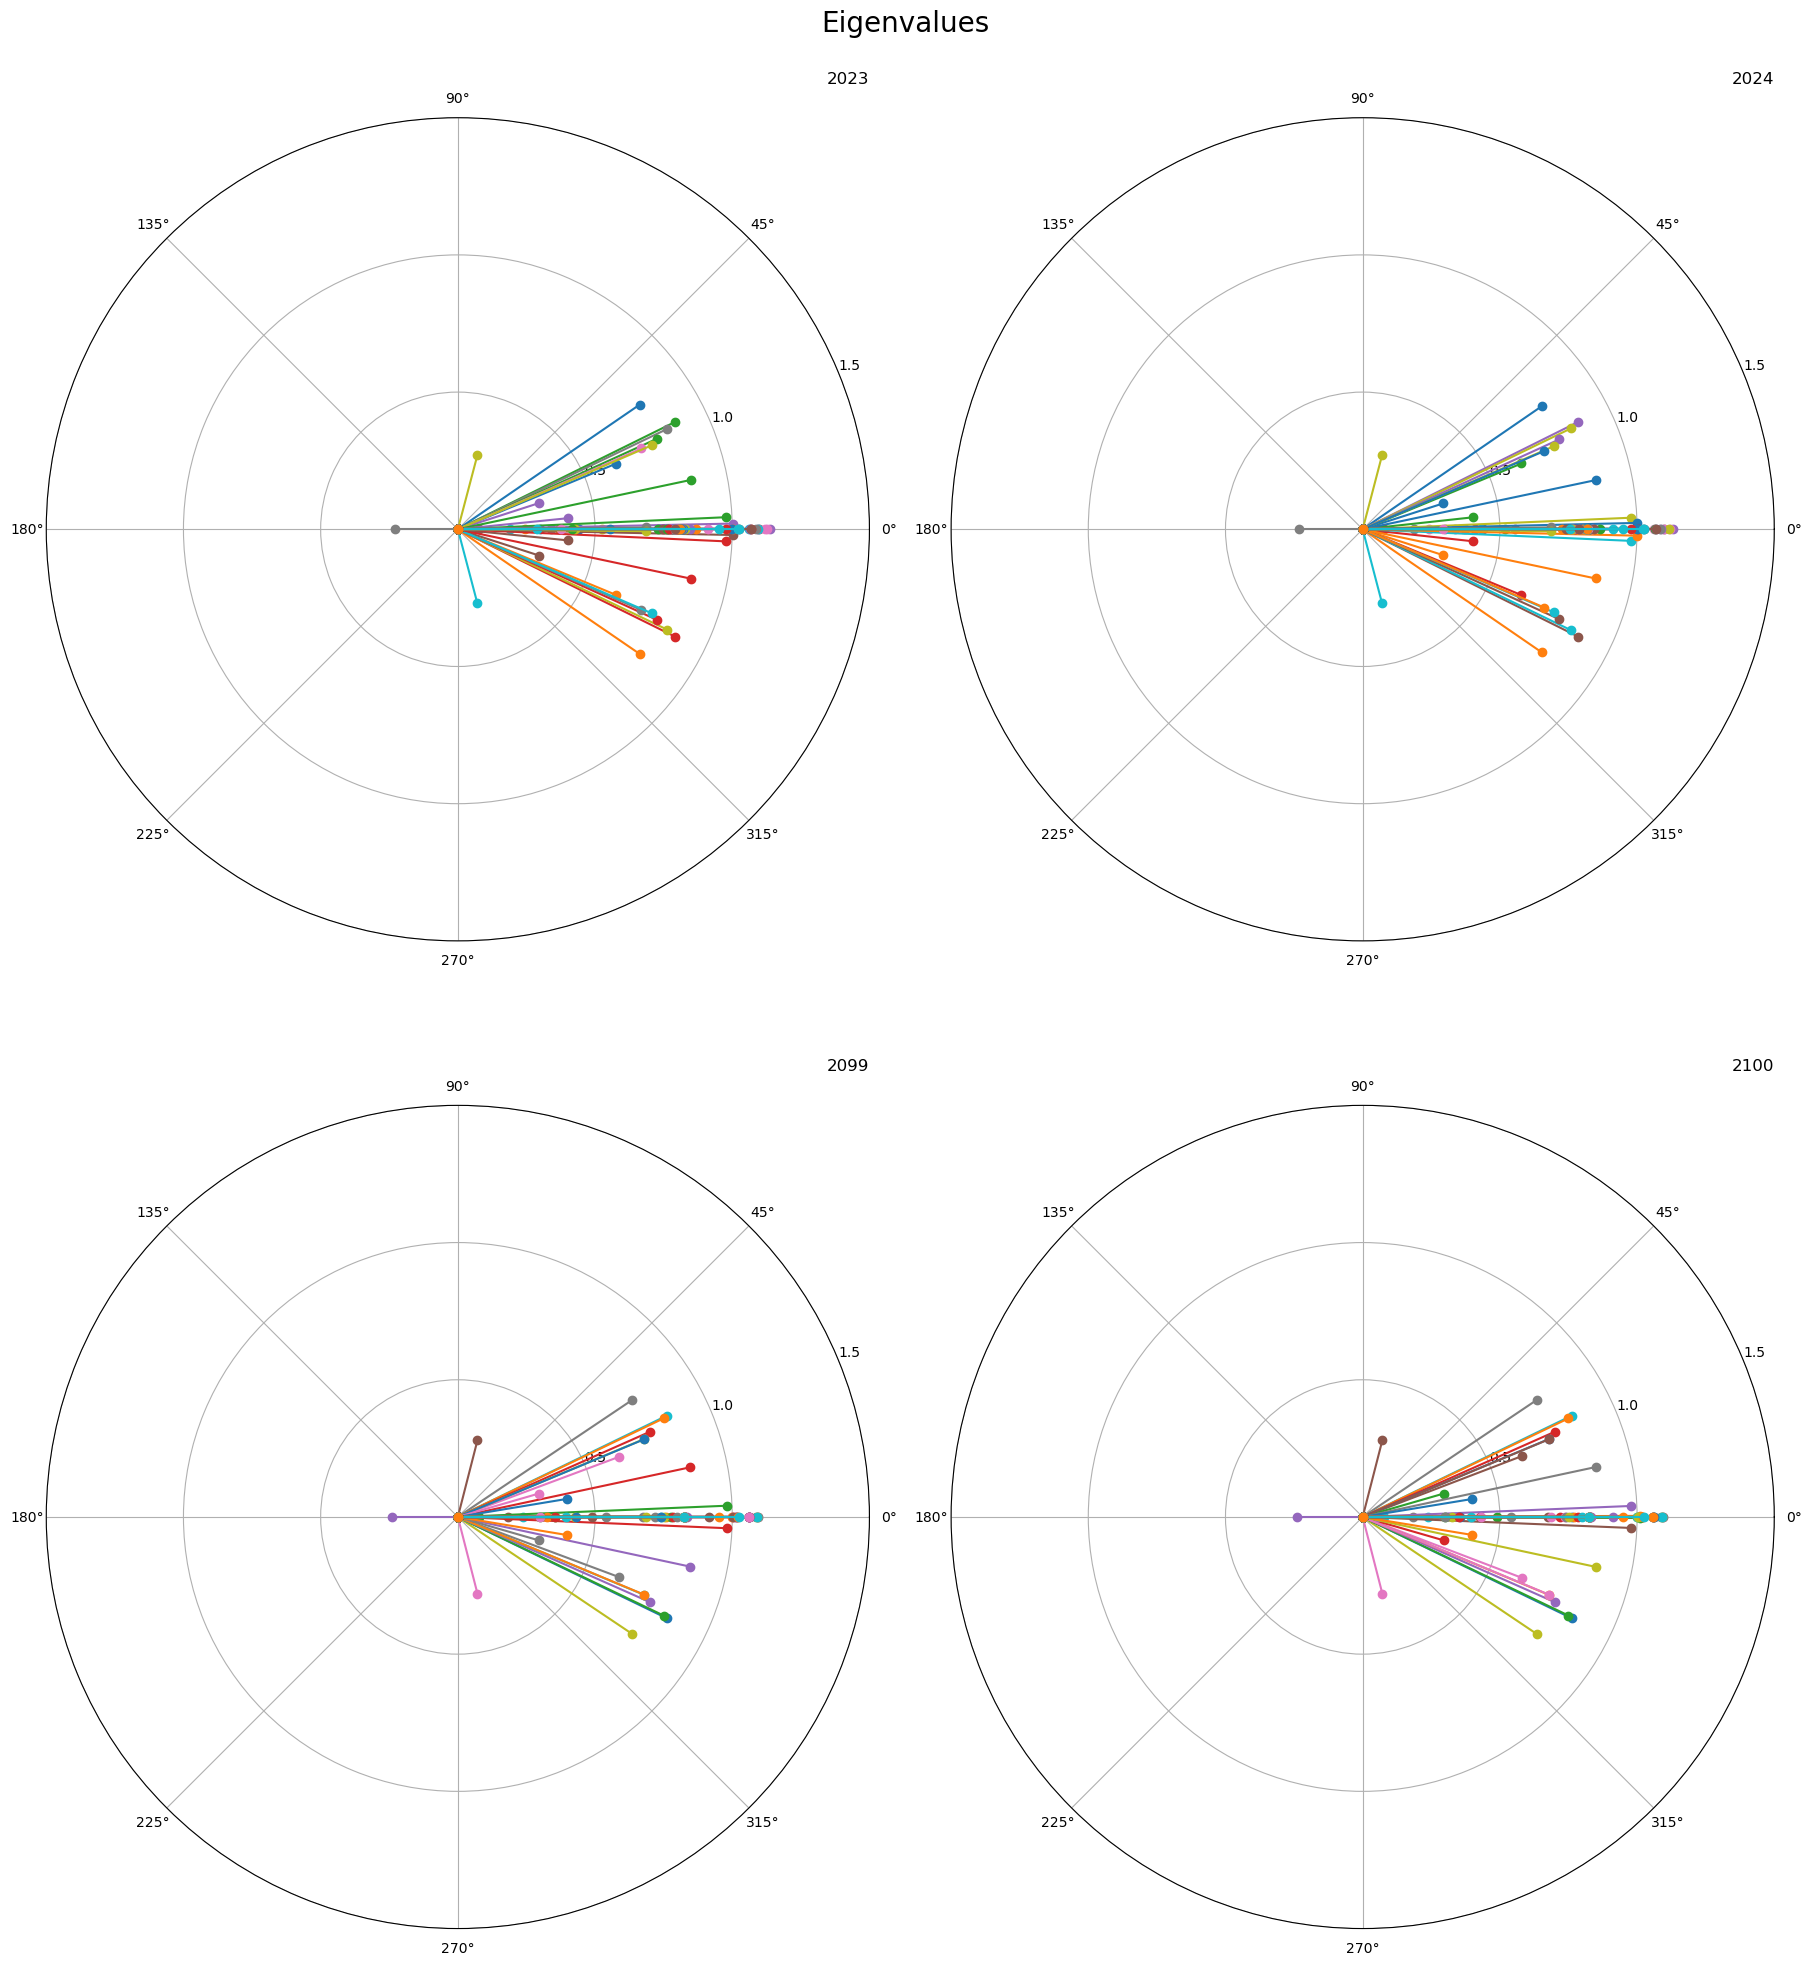

In [32]:
mpak_newton.eigplot_all(eig_dic,size=(1,1),maxfig=4,periode= [2023,2024,2099,2100]);

### Isolating potentially problematic eigenvalues

In the charts above it is clear that the vast majority of eigenvalues lie within the real unit circle and or have real roots, implying that the associated equations are dynamically stable.  

However, there are several that lie outside of the unit circle. The code below identifies and prints out those elements whose eigenvalues are greater than one in 2023, and in particular those with imaginary roots -- a source of instability.

In [53]:
eigen = eig_dic[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True,key=lambda x: x[1])
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True,key=lambda x: x[1])

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii:5} length: {abs(i):>10.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii:5} length: {abs(i):>.5f} real: {i.real:>8.5f} Imag: {i.imag:>8.5f}' for ii,i in gt1_imag],sep='\n')



Eigenvalues with length above 1 and only real: 
element   494 length:    1.13663 
element  1286 length:    1.12521 
element  1306 length:    1.12010 
element   455 length:    1.09868 
element   456 length:    1.09513 
element  1309 length:    1.09349 
element  1317 length:    1.08554 
element  1323 length:    1.06998 
element  1325 length:    1.06952 
element  1324 length:    1.06368 
element  1319 length:    1.06036 
element  1499 length:    1.02441 
element   495 length:    1.02299 
element  1419 length:    1.02000 
element   535 length:    1.00816 
element  1321 length:    1.00287 
  
Eigenvalues with length above 1 and imaginary: 
element  1314 length: 1.00303 real:  1.00282 Imag:  0.02085
element  1315 length: 1.00303 real:  1.00282 Imag: -0.02085


These results that 16 eigenvalues exceed 1 and that two exceed one and have imaginary roots.

### Look at all years 

The above routine was run for a single year, the code below can be run for multiple years.  Model data could cause an eigenvalue that was stable in one year to become unstable in another year. 


In [54]:
def print_eigenvalues_summary(eig_dic, print_all=False):
    """
    Prints a summary of eigenvalues with length > 1 

    Args:
    eig_dic (dict): A dictionary where keys are years and values are lists of eigenvalues.
    print_all (bool): If True, prints all years. If False, only prints years with non-zero imaginary eigenvalues.

    Returns:
    None
    """
    length_dict = {year: 
        {'lgt1_no_imag': len([i for i in eigen if abs(i) >= 1 and abs(i.imag) < 0.0000000001]),
         'gt1_imag': len([i for i in eigen if abs(i) >= 1 and i.imag > 0.00000001])} 
        for year, eigen in eig_dic.items()
    }

    print('Eigenvalues with length >= 1')
    for year, res in length_dict.items():
        if print_all or res["gt1_imag"] != 0:
            real_values = res["lgt1_no_imag"]
            imag_values = res["gt1_imag"] if res["gt1_imag"] != 0 else ""
            print(f'{year} With real values {real_values}, with imaginary values {imag_values}')


print_eigenvalues_summary(eig_dic, print_all=True)


Eigenvalues with length >= 1
2023 With real values 16, with imaginary values 1
2024 With real values 17, with imaginary values 
2025 With real values 16, with imaginary values 
2026 With real values 17, with imaginary values 
2027 With real values 16, with imaginary values 
2028 With real values 16, with imaginary values 
2029 With real values 16, with imaginary values 
2030 With real values 16, with imaginary values 
2031 With real values 15, with imaginary values 1
2032 With real values 16, with imaginary values 
2033 With real values 16, with imaginary values 
2034 With real values 16, with imaginary values 
2035 With real values 17, with imaginary values 
2036 With real values 16, with imaginary values 
2037 With real values 16, with imaginary values 
2038 With real values 16, with imaginary values 
2039 With real values 16, with imaginary values 
2040 With real values 17, with imaginary values 
2041 With real values 18, with imaginary values 
2042 With real values 17, with imagina

For the **Pakistan model**, all observed years exhibit **real eigenvalues**, suggesting an **exploding response** to shocks. There are instances where the eigenvalues indicate a response that is both **exploding and oscillating**. Nevertheless, for the explosion and oscillation effects to be significant, they need to persist over several years, which means the occasional occurrences might not have substantial effects.

In [57]:
_ = mpak(baseline,2023,2024)
eigenvalues_vectors = mpak.get_df_eigen_dict()[2023]


In [72]:
# Define a function which calculates a list of absolute values when served a dataframe column of complex numbers
compabs = lambda complex: [abs(value) for index,value in complex.items()]
def reorder_columns(df, second_column):
    """
    Reorders DataFrame columns to make 'second_column' the second column.
    """
    cols = list(df.columns)
    cols.insert(1, cols.pop(cols.index(second_column)))  # Move specified column to second position
    return df[cols]

def complex_to_abs(df):
    """
    Converts complex numbers to their absolute values for columns starting from the third column onwards.
    """
    cols_to_convert = df.columns[2:]  # Selecting the third column and onwards
    df.loc[:,cols_to_convert] = df.loc[:,cols_to_convert].applymap(np.abs)  # Apply np.abs to each element
    return df


eig_gt = (eigenvalues_vectors.   
                    T.        # Transpose as we query and eval on columns 
                    eval('absolute_value=@compabs(Eigenvalues)'). # calculate the absolute value of the eigenvalue 
                    query('absolute_value>=1.0').              # Select the rows where the abs value is above 0+.0001
                    pipe(reorder_columns,second_column='absolute_value').        
                    #drop('absolute_value',axis=1).                # We dont need the absolute value anymore, so the column is dropped. 
                    sort_values(by='absolute_value',ascending=False).
                    pipe(complex_to_abs).
                    T.T)   # Transpose again. 
testdf = eig_gt.head(20).copy()
testdf.head()

C:\Users\ibhan\AppData\Local\Temp\ipykernel_6540\943073147.py:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,cols_to_convert] = df.loc[:,cols_to_convert].applymap(np.abs)  # Apply np.abs to each element


494                     1301  \
Eigenvalues       (1.136630793330679+0j)  (1.125205465868375+0j)   
absolute_value                  1.136631                1.125205   
CHNEXR05(-1)                         0.0                     0.0   
CHNPCEXN05(-1)                       0.0                     0.0   
DEUEXR05(-1)                         0.0                     0.0   
...                                  ...                     ...   
PAKWHSLINTKN(-4)                     0.0                     0.0   
PAKXMKT(-4)                          0.0                     0.0   
PAKXMKT_GR(-4)                       0.0                     0.0   
TUREXR05(-4)                         0.0                     0.0   
TURPCEXN05(-4)                       0.0                     0.0   

                                     1309                     455   \
Eigenvalues       (1.1200998263481654+0j)  (1.0986838358403248+0j)   
absolute_value                     1.1201                 1.098684   
CHNEXR05(-1)                          0.0                      0.0   
CHNPCEXN05(-1)                        0.0                      0.0   
DEUEXR05(-1)                          0.0                      0.0   
...                                   ...                      ...   
PAKWHSLINTKN(-4)                      0.0                      0.0   
PAKXMKT(-4)                           0.0                      0.0   
PAKXMKT_GR(-4)                        0.0                      0.0   
TUREXR05(-4)                          0.0                      0.0   
TURPCEXN05(-4)                        0.0                      0.0   

                                    456   
Eigenvalues       (1.095126278951935+0j)  
absolute_value                  1.095126  
CHNEXR05(-1)                         0.0  
CHNPCEXN05(-1)                       0.0  
DEUEXR05(-1)                         0.0  
...                                  ...  
PAKWHSLINTKN(-4)                     0.0  
PAKXMKT(-4)                          0.0  
PAKXMKT_GR(-4)                       0.0  
TUREXR05(-4)                         0.0  
TURPCEXN05(-4)                       0.0  

[1514 rows x 5 columns]

In [71]:
17*(1.136631**20)

220.21092141690664

In [ ]:
len(eig_gt)

In [59]:
for i in range(len(eig_gt)-2):
    index = eig_gt.index[i]
    eigen  = eig_gt.iloc[i,0]
    length = eig_gt.iloc[i,2]
    vektor = eig_gt.iloc[i,3:].sort_values(ascending=False)[:20]
    print(index,eigen.real,eigen.imag)
    print(vektor)

494 1.136630793330679 0.0
PAKBNCABFUNDCN(-1)           0.593557
PAKBNCABFUNDCN(-2)           0.522207
PAKBNCABFUNDCN(-3)           0.459434
PAKBNCABFUNDCN(-4)           0.404207
PAKBXGSRNFSVCD(-1)           0.005563
PAKBNCABFUNDCD(-1)           0.005563
PAKBXGSRGNFSCD(-1)           0.005563
PAKBXGSRGNFSCD_FITTED(-1)    0.005563
PAKBNGSRNFSVCD(-1)           0.005563
PAKBNGSRGNFSCD(-1)           0.005563
PAKBNCABFUNDCD(-2)           0.004894
PAKBXGSRNFSVCD(-2)           0.004894
PAKBXGSRGNFSCD(-2)           0.004894
PAKBNGSRNFSVCD(-2)           0.004894
PAKBNGSRGNFSCD(-2)           0.004894
PAKBXGSRGNFSCD_FITTED(-2)    0.004894
PAKBNGSRGNFSCD(-3)           0.004306
PAKBXGSRGNFSCD_FITTED(-3)    0.004306
PAKBXGSRGNFSCD(-3)           0.004306
PAKBNGSRNFSVCD(-3)           0.004306
Name: 494, dtype: object
1301 1.125205465868375 0.0
PAKCCEMISCO2TKN(-1)    0.325719
PAKCCEMISCO2TKN(-2)    0.289475
PAKCCEMISCO2TKN(-3)    0.257264
PAKCCEMISCO2TKN(-4)    0.228638
PAKCCEMISCO2OKN(-1)    0.205996
PA

In [ ]:
eig_gt['PAKBNCABFUNDCN(-1)'].sort_values()

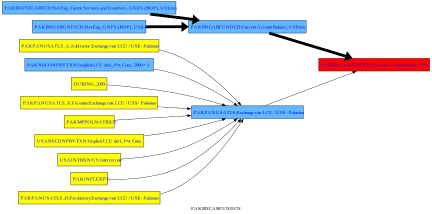

In [66]:
mpak.PAKBNCABFUNDCN.tracepre(up=2)

In [ ]:
mpak.PAKBNCABFUNDCN

## Dealing with potential instability

Unfortunately there is no one-to-one relationship between equations and eigenvalues. It may be that certain equations are inherently unstable, error-correction models where the speed of adjustment is greater than one for example.  Equation results can be inspected for such sources of instability.  

Other sources of instability may be more subtle and lie in the interaction of coefficients across equations.  One approach to identifying potentially problematic equations is to perform a grid-search by recalculating the eigenvalues of the system after eliminating one equation, and repeating this operation for every equation in the system. 

The elimination of an ill-formed equation is likely to cause large and greater than one eigenvalues to shrink and potentially even fall within the unit circle and may cause eigenvalues with imaginary roots to disappear. Such a reaction would seem to indicate that the excluded equation lies within the nexus of relationships that are generating potential instability. It is of course possible that several equations lie within the same nexus and have the same effect when eliminated of getting rid of the unstable eigenvector.

:::{index} single: stability; .get_eigen_jackknife_df() method
:::
:::{index} single: eigenvalues; .get_eigen_jackknife_df() method
:::
:::{index} single: modelflow; .get_eigen_jackknife_df() method
:::


### The `.get_eigen_jackknife_df()` method

Modelflow includes a jackknife algorithm (`.get_eigen_jackknife_df()`) that systematically drops one-by-one each equation from the model, and then recalculates the eigenvalues of the smaller model. The  eigenvalues for each new model (each comprised of the one less than the N equations of the original model) are returned as a tall or stacked dataframe. 

The routine sums the 20 largest eigenvalues each time an equation is omitted.  By keeping track of the size of the largest eigenvalues, the algorithm seeks to identify one (or more) equations that have a large influence on the eigenvalues of the system. 

Equations whose omission from the model reduces the largest eigenvalues the most are most likely to be the source of model instability.

For a large model, this can be a time-consuming exercise (7-12 minutes for mpak over two years, depending on the user's processor).


To test code, the parameter maxnames can be set to restrict the number of re-samplings.


### Look at only 2 years
For the sake of execution time a new mpak_newton is created with only 2 years. 

Below the `get_eigen_jackknife` routine systematically calcualtes the eigenvalue of 303 different versions of the model, the original model and then 302 models equal to the original model less one equation.  This is a time consuming exercise on a model the size of mpak.

In [ ]:
jackdf  = mpak_newton.get_eigen_jackknife_df()

In [ ]:
jackdf.to_csv('jackdf.csv')

In [ ]:
!dir

### The structure of jackdf

The dataframe returned by the routine contains a stacked (tall) dataframe showing the all the eigenvalue, and their assocaited levels length, real and imaginary values for each variant of the model.  The excluded column indicates what equation was excluded and the exclude description gives a more verbose indication of the change.  The first set of eigenvalues are for the whole model and the last are for the model when the last equation () is excluded.


The returned  dataframe has the following columns:

| Column     | Explanation                                         |
|:-----------|:-----------------------------------------------------|
| excluded   | The name or identifier of the excluded variable.    |
| year       | The year associated with the data row.              |
| index      | The index or position of the row in the dataset.    |
| value      | The computed or observed value for the row.         |
| length     | The absolute length or magnitude of the `value`.    |
| realvalue  | The real part of the `value` if it's complex.       |
| imagvalue  | The imaginary part of the `value` if it's complex.  |
|excluded_description| The description of the variable for which the equation is excluded|

In [ ]:
jackdf.head() # The first 5 rows of the returned dataframe

In [ ]:
jackdf.tail()# The final 5 rows of the returned dataframe (note these are for year 2004 vs 2003 at the beginning)

## Examining the results of the grid search

The query command return all rows from the dataframe that match a specific criteria.  

In the example below, returns all rows where excluded is = NONE (i.e.where no variable was excluded) **and** the absolute value of the imaginary number of the eigenvector is not 0 **and** the year is 2003.

As it turns out, there is only one eigenvalue with length greater than one and  and imaginary value different from 0 (recall imaginary values always return in pairs: a positive number and the numerically identical  negative number). 

i.e. the eigenvectors with value greater than one and imaginary roots.

In [ ]:
jackdf.query('excluded =="NONE" & length > 1 & abs(imagvalue) != 0.0 &  year == 2023')

##  A query to indicate which equations, when deleted have unstable eigenvalues


Apparently for 285 equations the model in 2023 is still unstable if the equations are deleted, implying that for 303-285=18 sub-models when one equation was deleted there were no unstable eigenvalues.

In [ ]:
jackdf.query('length > 1 & imagvalue >= 0.0 &  year == 2023')

## Identifying potentially troublesome equations

To identify potentially troublesome equations we interrogate the database for submodels, which when a specific equations is omitted no-longer have eigenvalues greater than one that also have imaginary roots.

Effectively if, when an equation is excluded from the model, the truncated model has no eigenvalue outside the unit root with imaginary roots -- that suggests quite strongly that the excluded equation plays is playing a part in the instability of the model. 

The procedure below goes through the tall dataframe and returns only those rows where no eigenvalue for the group identified by the excluded variable has an eigenavlue >1 and imaginary roots.  For these variables exclusion of its equation eliminated the instability in the residual model.



In [ ]:
def get_unique_excluded(df, year, excluded_col='excluded', description_col='excluded_description'):
    """
    Filters the DataFrame for a specific year and returns unique values of 'excluded' and their descriptions,
    where no row in the group satisfies both conditions (length > 1 and imagvalue > 0).

    Args:
    df (pandas.DataFrame): The DataFrame to process.
    year (int): The year to filter the DataFrame.
    excluded_col (str): The name of the column containing excluded variables. Default is 'excluded'.
    description_col (str): The name of the column containing descriptions of excluded variables. Default is 'excluded_description'.

    Returns:
    tuple: A tuple containing two arrays - unique excluded descriptions and unique excluded variables.
    """
    # Filter DataFrame for the specified year and apply the conditions
    filtered_df = df.query('year == @year').groupby(excluded_col).filter(
        lambda x: ~((x['length'] > 1) & (x['imagvalue'] > 0)).any()
    )

    # Extract unique values
    unique_descriptions = filtered_df[description_col].unique()
    unique_variables = filtered_df[excluded_col].unique()

    return unique_descriptions, unique_variables

unique_excluded_descriptions, unique_excluded_variables = get_unique_excluded(jackdf, 2023)
print(unique_excluded_descriptions)


## Show the EViews equations for the equations. 

Now that a list of potentially problematic equations has been extracted from the model, their equations can be examined for any obvious factors that might be de-stabilizing, such as a speed of adjustment in an ECM equation that was negative or greater than 2.

For World Bank models the equations are usually easier to read in their estimated form, which can be extracted by passing a space-delimited string of the mnemonics of the selected variables to the the eviews command.

A quick inspection reveals no obvious candidates for an equation that is itself inherently unstable. 

However, the levels of  several equations are not constrained in several instances, which means they could be unstable. 

In [ ]:
string_of_excluded_variables = ' '.join(unique_excluded_variables)
mpak[string_of_excluded_variables].eviews

## Show the modelflow equations. 

The equations can also be inspected in their normalized level form.

In [ ]:
mpak[string_of_excluded_variables].frml

# Drawing conclusions about the instability in the model


Interestingly the returned variables include four variables surrounding the government accounts.  Indicating that left to its own devices the equations for government spending could send the model into an unstable state.   While from a technical solution of a system of differential equations  point of view this might be worrisome, from an economic point of view this is actually a desirable feature.

It indicates that in the absence of a fiscal rule to constrain spending or to ensure revenues expand, it is possible for the government debt to grow in an unstable manner, causing model instability. 

The economic translation of that condition is that there is nothing in the estimated behaviour of government spending and revenues to prevent a debt crisis from emerging. And indeed, Pakistan is a country that has found itself in debt distress in several instances, so this model "instability" would appear to reflect a real instability in the economy and as such may be a desirable feature.  Elimination (which is to say exogenization of government expenditure or the debt accumulation equation would be sufficient to eliminate the risk of instability.

The other unconstrained variables are the price variables.  Again this is not a problem for economic theory, which advises that the rate of inflation should stabilize but says nothing about the price level which in MFMod and in most countries is indeterminate.  

Economic theory tells us that inflation should stabilize over time, but the price level at which it stabilizes can be (and usually is) constantly rising -- exponentially in some countries but not most.

The other nexus of potentially unstable variables pertain to the level of GDP, which is also not bound except by potential output in the Pakistan model, a factor that is not in itself a problem as long as the price mechanisms work to close the output gap.

What about private investment?? 

 
 'PAKNEGDIFPRVKN Prvt. Investment real' 'PAKNEGDIFTOTKN Investment real'
 'PAKNEGDIFTOTKN2' 'PAKNEGDIKSTKKN Capital stock, LCU'
 
 